# StrategicFL: FEMNIST Demo Experiment 

Demonstrating strategic federated learning with adversarial clients

In [4]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch

# Import framework components
from femnistdataset import FEMNISTDataset
from torch import nn
from torch.utils.data import DataLoader

from models import CNN
from strategicfl.agents import Client, Server
from strategicfl.utils.actions import create_scalar_action
from strategicfl.utils.aggregation import get_aggregate
from strategicfl.utils.evaluate import evaluate_with_ids
from strategicfl.utils.metrics import get_gradient_metrics

## Preparation/initialization

### Setup device

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
elif torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple M-series
else:
    device = torch.device("cpu")  # CPU

print(f"Using device: {device}")

Using device: mps


### Setup experiment configuration

In [16]:
config = {
    "training": {
        "T": 100,  # Number of training rounds
        "lr": 0.06,  # Learning rate
        "local_steps": 2,  # Local SGD steps
        "batch_size": 32,
        "eval_batch_size": 128,
    },
    "clients": {
        "n_players": 3,  # Number of client groups
        "alpha_0": 1.0,  # Good client scaling
        "alpha_1": 1.0,  # Bad client scaling; Not really bad here, this is for illustrative purposes of the functionality of the package
        "beta_0": 0.0,  # Honest client noise
        "beta_1": 0.0,  # Adversarial client noise
    },
    "aggregation": {
        "method": "mean"  # Can be 'mean', 'median', 'trimmed_mean'
    },
    "data": {
        "train_path": "../../data/femnist/train.json",
        "test_path": "../../data/femnist/test.json",
    },
}

print("Configuration:")
for section, values in config.items():
    print(f"  {section}:")
    for key, value in values.items():
        print(f"    {key}: {value}")

Configuration:
  training:
    T: 100
    lr: 0.06
    local_steps: 2
    batch_size: 32
    eval_batch_size: 128
  clients:
    n_players: 3
    alpha_0: 1.0
    alpha_1: 1.0
    beta_0: 0.0
    beta_1: 0.0
  aggregation:
    method: mean
  data:
    train_path: ../../data/femnist/train.json
    test_path: ../../data/femnist/test.json


### Loading the FEMNIST data

In [17]:
def get_data(path: str):
    with open(path, "r") as f:
        data = json.load(f)
        user_names = list(data.keys())
    return data, user_names


print("\nLoading FEMNIST data...")
data_dict, user_names = get_data(config["data"]["train_path"])
test_data_dict, _ = get_data(config["data"]["test_path"])

print(f"Training data: {len(user_names)} users")
print(f"Sample user data size: {len(data_dict[user_names[0]]['x'])} samples")


Loading FEMNIST data...
Training data: 3597 users
Sample user data size: 139 samples


### Creating a Server agent with CNN model

In [12]:
print("\nCreating server...")
server_model = CNN().to(device)

# Enable compilation for better performance (if available)
if device.type == "cuda":
    server_model = torch.compile(server_model, mode="reduce-overhead")

server = Server(
    device=device,
    model=server_model,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(server_model.parameters(), lr=config["training"]["lr"]),
    aggregate_fn=get_aggregate(method=config["aggregation"]["method"]),
)

print(f"Created server with {config['aggregation']['method']} aggregation")


Creating server...
Created server with mean aggregation


### Creating a group of Client agents

In [33]:
print("\nCreating clients...")
split_index = len(user_names) // config["clients"]["n_players"]
clients = []

for i in range(config["clients"]["n_players"]):
    # Split users among clients
    start_idx = max(0, i * split_index)
    end_idx = min((i + 1) * split_index, len(user_names))
    client_user_names = user_names[start_idx:end_idx]

    # Last client is adversarial, others are honest
    if i == config["clients"]["n_players"] - 1:
        alpha = config["clients"]["alpha_1"]
        beta = config["clients"]["beta_1"]
        agent_id = "adversarial"
        print(f"  Client {i + 1}: BAD (a={alpha}, b={beta})")
    else:
        alpha = config["clients"]["alpha_0"]
        beta = config["clients"]["beta_0"]
        agent_id = f"honest_{i}"
        print(f"  Client {i + 1}: GOOD (a={alpha}, b={beta})")

    # Create datasets
    train_dataset = FEMNISTDataset(client_user_names, data_dict)
    test_dataset = FEMNISTDataset(client_user_names, test_data_dict)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config["training"]["batch_size"],
        shuffle=True,
        pin_memory=True if device.type == "cuda" else False,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config["training"]["eval_batch_size"],
        shuffle=False,
        pin_memory=True if device.type == "cuda" else False,
    )

    # Create client model
    client_model = CNN().to(device)
    if device.type == "cuda":
        client_model = torch.compile(client_model, mode="reduce-overhead")

    client = Client(
        device=device,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        model=client_model,
        criterion=nn.CrossEntropyLoss().to(device),
        optimizer=torch.optim.SGD(
            client_model.parameters(), lr=config["training"]["lr"]
        ),
        action=create_scalar_action(alpha, beta),
        agent_id=agent_id,
    )

    clients.append(client)


Creating clients...
  Client 1: GOOD (a=1.0, b=0.0)
  Client 2: GOOD (a=1.0, b=0.0)
  Client 3: BAD (a=1.0, b=0.1)


## Run federated training

In [34]:
print(f"\nStarting federated training for {config['training']['T']} rounds...")

all_losses, all_metrics = server.train(
    clients=clients,
    T=config["training"]["T"],
    get_metrics=get_gradient_metrics,
)

print("Training completed!")


Starting federated training for 100 rounds...


Federated Training: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]

Training completed!


## Evaluate final performance

In [35]:
print("\nEvaluating final performance...")
final_accuracy, final_loss = evaluate_with_ids(server, clients)


Evaluating final performance...
honest_0: Accuracy = 0.0435, Loss = 3.7738
honest_1: Accuracy = 0.0592, Loss = 3.6508
adversarial: Accuracy = 0.0561, Loss = 3.6585


## Visualize training process

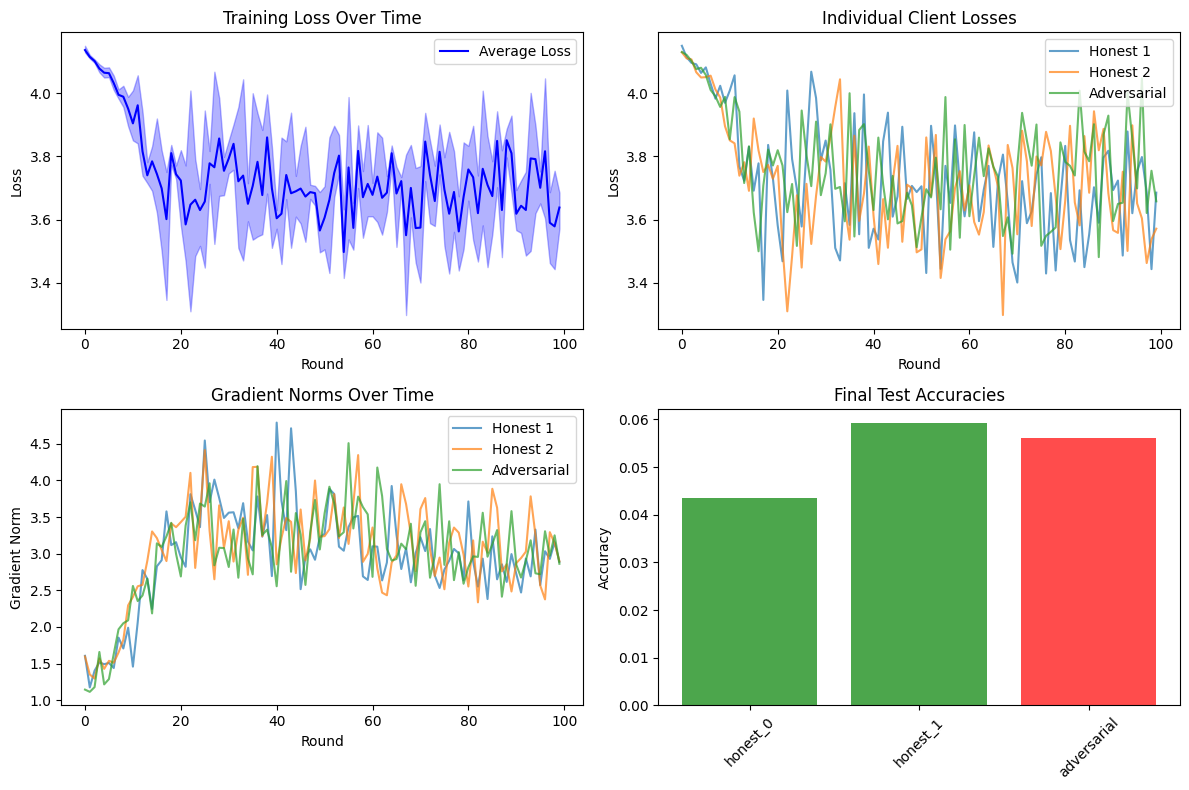

In [ ]:
losses_array = np.array(
    [[loss for loss in round_losses] for round_losses in all_losses]
)
grad_norms_array = np.array([metrics["grad_norms"] for metrics in all_metrics])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Training losses over time
axes[0, 0].plot(losses_array.mean(axis=1), label="Average Loss", color="blue")
axes[0, 0].fill_between(
    range(len(losses_array)),
    losses_array.min(axis=1),
    losses_array.max(axis=1),
    alpha=0.3,
    color="blue",
)
axes[0, 0].set_title("Training Loss Over Time")
axes[0, 0].set_xlabel("Round")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()

# Individual client losses
for i in range(config["clients"]["n_players"]):
    client_type = (
        "Adversarial" if i == config["clients"]["n_players"] - 1 else f"Honest {i + 1}"
    )
    axes[0, 1].plot(losses_array[:, i], label=client_type, alpha=0.7)
axes[0, 1].set_title("Individual Client Losses")
axes[0, 1].set_xlabel("Round")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Gradient norms
for i in range(config["clients"]["n_players"]):
    client_type = (
        "Adversarial" if i == config["clients"]["n_players"] - 1 else f"Honest {i + 1}"
    )
    axes[1, 0].plot(grad_norms_array[:, i], label=client_type, alpha=0.7)
axes[1, 0].set_title("Gradient Norms Over Time")
axes[1, 0].set_xlabel("Round")
axes[1, 0].set_ylabel("Gradient Norm")
axes[1, 0].legend()

# Final loss bar plot
client_ids = list(final_loss.keys())
loss = [float(final_loss[client_id]) for client_id in client_ids]
colors = [
    "red"
    if "adversarial" in client_id.lower() or "bad" in client_id.lower()
    else "green"
    for client_id in client_ids
]
axes[1, 1].bar(client_ids, loss, color=colors, alpha=0.7)
axes[1, 1].set_title("Final Test Loss")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Experiment summary

In [ ]:
print("\n" + "=" * 50)
print("EXPERIMENT SUMMARY")
print("=" * 50)
print("\nConfiguration:")
print(
    f"  Honest clients (a={config['clients']['alpha_0']}, b={config['clients']['beta_0']})"
)
print(
    f"  Adversarial client (a={config['clients']['alpha_1']}, b={config['clients']['beta_1']})"
)
print(f"  Training rounds: {config['training']['T']}")

print(f"\nFinal Results with {config['aggregation']['method']} aggregation:")
for client_id, acc in final_accuracy.items():
    loss = final_loss[client_id]
    acc_val = float(acc) if hasattr(acc, "item") else acc
    loss_val = float(loss) if hasattr(loss, "item") else loss
    print(f"  {client_id}: {acc_val:.4f} accuracy, {loss_val:.4f} loss")

# For the final comparison, get the adversarial client's performance
adversarial_acc = final_accuracy.get("bad", final_accuracy.get("adversarial"))
honest_accs = [
    final_accuracy[k]
    for k in final_accuracy.keys()
    if k != "bad" and k != "adversarial"
]

if adversarial_acc is not None and honest_accs:
    adversarial_val = (
        float(adversarial_acc) if hasattr(adversarial_acc, "item") else adversarial_acc
    )
    honest_vals = [float(acc) if hasattr(acc, "item") else acc for acc in honest_accs]

### [Optional] Saving the results

In [ ]:
results = {
    "config": config,
    "final_accuracy": final_accuracy,
    "final_loss": final_loss,
    "training_losses": losses_array,
    "gradient_norms": grad_norms_array,
}

with open("strategicfl_demo_femnist.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to strategicfl_demo_femnist.pkl")